In [3]:
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction import text 
import pandas as pd
import matplotlib.pyplot as plt
from wordcloud import WordCloud
import numpy as np
from mpl_toolkits.mplot3d import Axes3D 
from sklearn.metrics import classification_report
from IPython.display import display
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import gensim
from adjustText import adjust_text
import multiprocessing

In [4]:
cores = multiprocessing.cpu_count()

In [5]:
df_data = pd.read_csv('../Data/data_3/clean_review.csv')

In [6]:
encoding_label = {
    'positive': 0,
    'neutral': 1,
    'negative': 2
}


In [7]:
df_data['label'] = df_data['label'].map(encoding_label)
df_data

,rating,text,label
0,2.0,near airport with good shuttle service stay he...,2
1,1.0,get a low ranking for a reason I have few posi...,2
2,2.0,budget hotel pretend to be a resort the hanale...,2
3,1.0,dish out a few extra buck and stay elsewhere t...,2
4,2.0,l a on a budget the good low cost for a brand ...,2
...,...,...,...
141742,5.0,fantastic mid range hotel u will not find well...,0
141743,4.0,fantastic service all the staff that I encount...,0
141744,4.0,a great find we stay here for DATE DATE previo...,0
141745,4.0,convenient location for the airport we stay he...,0


In [8]:
x_train, x_test, y_train, y_test = train_test_split(df_data['text'], df_data['label'], test_size=0.2, random_state=42)
x_test, x_val, y_test, y_val = train_test_split(x_test, y_test, test_size=0.5, random_state=42)
x_train.shape, x_test.shape, y_train.shape, y_test.shape, x_val.shape, y_val.shape

((113397,), (14175,), (113397,), (14175,), (14175,), (14175,))

In [10]:
sentences = df_data['text'].str.split().tolist()

model_wv = gensim.models.Word2Vec(sentences, vector_size=200, window=9, min_count=1, workers=cores-1)

In [14]:
words = list(model_wv.wv.key_to_index)[:200]
embeddings = model_wv.wv[words]

pca = PCA(n_components=10, random_state=42).fit_transform(embeddings)
embeddings_2d = TSNE(n_components=2, random_state=42, perplexity=5).fit_transform(pca)

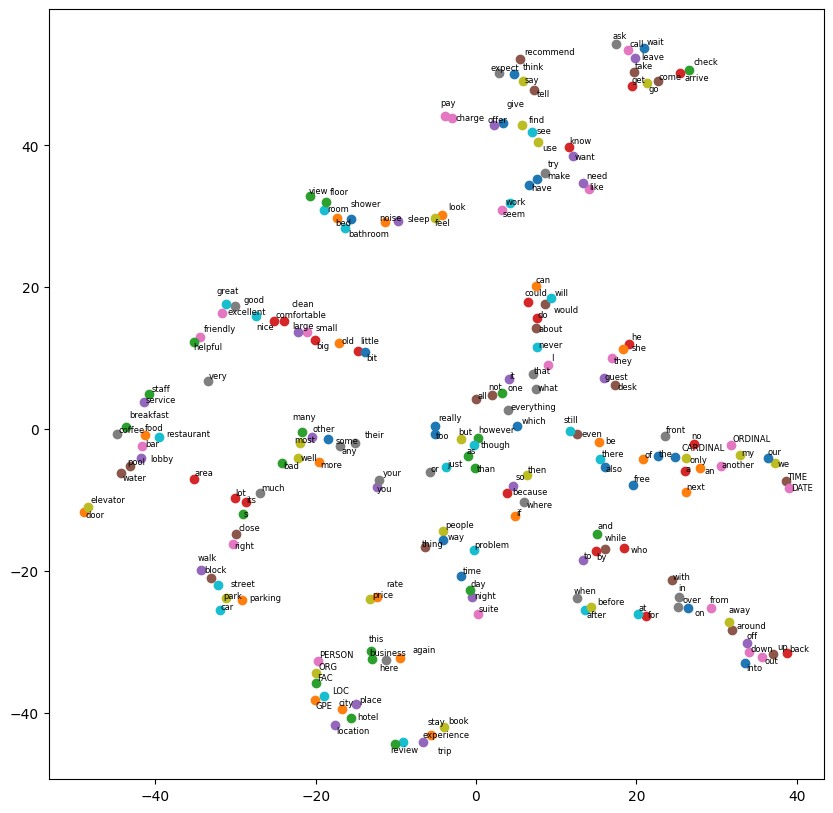

In [15]:
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111)

for i, word in enumerate(words):
    x, y = embeddings_2d[i]
    ax.scatter(x, y)
    ax.text(x, y, word, fontsize=6)

adjust_text(ax.texts)
plt.show()

In [42]:
MAXLEN = 32
MAX_EXAMPLES = len(model_wv.wv.key_to_index)
EMBEDDING_DIM = model_wv.wv.vector_size
TRUNCATING = 'post'
PADDING = 'post'
OOV_TOKEN = '<OOV>'
NUM_LABELS = 5

embedding_matrix = np.zeros((MAX_EXAMPLES, EMBEDDING_DIM))
for word, i in model_wv.wv.key_to_index.items():
    embedding_matrix[i] = model_wv.wv[word]

In [43]:
tokenizer = Tokenizer(num_words=MAX_EXAMPLES, oov_token=OOV_TOKEN)
tokenizer.fit_on_texts(x_train)
word_index = tokenizer.word_index
x_train_seq = tokenizer.texts_to_sequences(x_train)
x_train_pad = pad_sequences(x_train_seq, maxlen=MAXLEN, truncating=TRUNCATING, padding=PADDING)
x_test_seq = tokenizer.texts_to_sequences(x_test)
x_test_pad = pad_sequences(x_test_seq, maxlen=MAXLEN, truncating=TRUNCATING, padding=PADDING)

In [44]:
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(MAX_EXAMPLES, EMBEDDING_DIM, input_length=MAXLEN,weights=[embedding_matrix], trainable=False),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(NUM_LABELS, activation='softmax')
])

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy', tf.keras.metrics.TruePositives(), tf.keras.metrics.TrueNegatives(), tf.keras.metrics.FalsePositives(), tf.keras.metrics.FalseNegatives()])
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 32, 200)           7076800   
                                                                 
 flatten_1 (Flatten)         (None, 6400)              0         
                                                                 
 dense_2 (Dense)             (None, 64)                409664    
                                                                 
 dense_3 (Dense)             (None, 5)                 325       
                                                                 
Total params: 7,486,789
Trainable params: 409,989
Non-trainable params: 7,076,800
_________________________________________________________________


In [45]:
history = model.fit(x_train_pad, y_train, epochs=10, validation_data=(x_test_pad, y_test))

Epoch 1/10
513/513 [==============================] - 2s 4ms/step - loss: 1.3279 - accuracy: 0.4359 - true_positives_1: 3473.0000 - true_negatives_1: 62534.0000 - false_positives_1: 3034.0000 - false_negatives_1: 12919.0000 - val_loss: 1.2449 - val_accuracy: 0.4621 - val_true_positives_1: 989.0000 - val_true_negatives_1: 15628.0000 - val_false_positives_1: 768.0000 - val_false_negatives_1: 3110.0000
Epoch 2/10
513/513 [==============================] - 2s 3ms/step - loss: 1.0721 - accuracy: 0.5527 - true_positives_1: 5650.0000 - true_negatives_1: 62838.0000 - false_positives_1: 2730.0000 - false_negatives_1: 10742.0000 - val_loss: 1.2409 - val_accuracy: 0.4652 - val_true_positives_1: 1231.0000 - val_true_negatives_1: 15425.0000 - val_false_positives_1: 971.0000 - val_false_negatives_1: 2868.0000
Epoch 3/10
513/513 [==============================] - 2s 3ms/step - loss: 0.9029 - accuracy: 0.6444 - true_positives_1: 7666.0000 - true_negatives_1: 62992.0000 - false_positives_1: 2576.0000 -

In [ ]:
val_accuracy, val_loss = model.evaluate(x_val_pad, y_val)

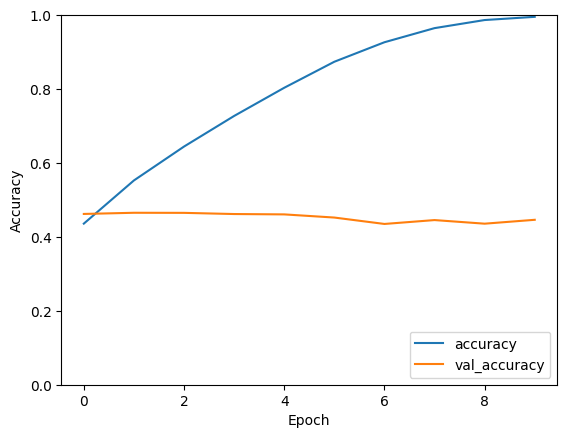

In [46]:
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label='test_accuracy')
plt.plot(val_accuracy, label='val_accuracy',marker='o', color='green')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0, 1])
plt.legend(loc='lower right')
plt.show()